# Analysing 10 years of meditation data from Meditation Helper pro app

They don't make it easy!

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import calplot


# Import data and convert to dataframe

In [16]:
#read in data as text
with open('exported-sittings-20231005092003.csv') as f:
    rawdata = f.readlines()

#convert to ascii with list comprehension
asciidata = [line.encode('ascii', 'replace') for line in rawdata]



In [17]:
sittings = pd.DataFrame(columns = ['StartTime', 'EndTime', 'SessionType', 'Comment','Duration'])

#parse data
for row in asciidata:
    row = str(row).split('?')
    if len(row) > 2:
        start = datetime.datetime.strptime(row[2], '%Y-%m-%d %H:%M:%S')
        end = datetime.datetime.strptime(row[3], '%Y-%m-%d %H:%M:%S')
    if len(row) == 5:
        sittings.loc[len(sittings)] = {'StartTime': start, 'EndTime': end, 'SessionType': int(row[4])/1000}
    elif len(row) == 6:
        sittings.loc[len(sittings)] = {'StartTime': start, 'EndTime': end, 'SessionType': int(row[4])/1000, 'Comment': row[5]}

In [18]:
sittings.head()

,StartTime,EndTime,SessionType,Comment,Duration
0,2013-08-01 23:10:00,2013-08-01 23:20:00,600.0,\n',NaN
1,2013-08-02 21:03:30,2013-08-02 21:10:30,360.0,\n',NaN
2,2013-08-03 14:41:08,2013-08-03 14:48:08,360.0,\n',NaN
3,2013-08-04 20:58:38,2013-08-04 21:05:38,360.0,\n',NaN
4,2013-08-04 21:05:47,2013-08-04 21:12:47,360.0,\n',NaN


In [19]:
def toseconds(x):
    return x.seconds

In [20]:
#let's calculate exact durations in seconds 
sittings["Duration"] = (sittings["EndTime"] - sittings["StartTime"])
sittings["Duration"] = sittings["Duration"].apply(toseconds)


In [21]:
sittings.to_csv('sittings.csv', index=False)

# Find all sittings in given time periods

In [32]:
sittings = pd.read_csv('sittings.csv', parse_dates=['StartTime', 'EndTime'])
sittings.head()

,StartTime,EndTime,SessionType,Comment,Duration
0,2013-08-01 23:10:00,2013-08-01 23:20:00,600.0,\n',600
1,2013-08-02 21:03:30,2013-08-02 21:10:30,360.0,\n',420
2,2013-08-03 14:41:08,2013-08-03 14:48:08,360.0,\n',420
3,2013-08-04 20:58:38,2013-08-04 21:05:38,360.0,\n',420
4,2013-08-04 21:05:47,2013-08-04 21:12:47,360.0,\n',420


In [23]:
# with dataframes we can easily select all sittings that start or end in a given period
sits = sittings
starttime = datetime.datetime(2023,10,4,0,0,0)
endtime = datetime.datetime(2023,10,5,0,0,0)

theseSittings = sits[sits.StartTime.between(starttime, endtime) | sits.EndTime.between(starttime , endtime)]

theseSittings

,StartTime,EndTime,SessionType,Comment,Duration
5427,2023-10-04 07:00:27,2023-10-04 08:01:45,3674.164,\n',3678
5428,2023-10-04 09:13:59,2023-10-04 09:40:34,1590.799,\n',1595
5429,2023-10-04 15:11:52,2023-10-04 15:40:16,1699.190,\n',1704
5430,2023-10-04 15:51:41,2023-10-04 17:02:06,4224.267,\n',4225
5431,2023-10-04 17:04:25,2023-10-04 17:32:22,1672.141,\n',1677
5432,2023-10-04 19:01:34,2023-10-04 21:06:04,7464.838,\n',7470
5433,2023-10-04 22:11:26,2023-10-04 23:10:50,3559.378,\n',3564


In [24]:
def activityInPeriod(sits, starttime, endtime ):
    '''Find all sittings between two times and return a [PeriodLengthInMinutes x 1] array
    with one cell per minute containing Zero if not sitting, one if sitting.
    Includes partial sittings (starting before and ending after the period)
    For each interval we round seconds to nearest minute (up or down). 
    sits - dataframe with sittings
    starttime - datetime object with start of period
    endtime - datetime object with end of period
    return
    numsits - number of sittings in interval
    thisPeriod - a numpy array with one cell per minute in the period, with 1 if sitting, 0 if not sitting

    '''

    periodLength =   round((endtime - starttime).total_seconds()/60)
    thisPeriod = np.zeros(periodLength, dtype=int)
    #all sittings that start or end in this period
    theseSittings = sits[sits.StartTime.between(starttime, endtime) | sits.EndTime.between(starttime , endtime)]
    numsits = len(theseSittings)
    for idx in theseSittings.index:
        #get start and end of this sitting
        sitstart = theseSittings["StartTime"][idx]
        sitend = theseSittings["EndTime"][idx]
        #turn into relative points in the period
        startminute = round((max(sitstart, starttime) - starttime).total_seconds()/60)
        endminute = round((min(sitend, endtime) - starttime).total_seconds()/60)
        thisPeriod[startminute:endminute] = 1

    return numsits, thisPeriod


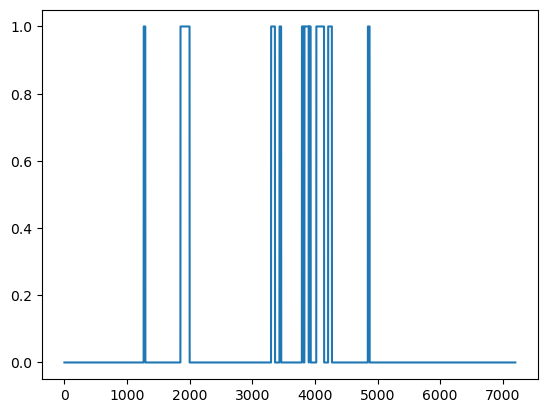

In [25]:
starttime = datetime.datetime(2023,10,2,0,0,0)
endtime = datetime.datetime(2023,10,7,0,0,0)

n, today = activityInPeriod(sittings, starttime, endtime)

plt.plot(today)

In [19]:
print(theseSittings.iloc[0].StartTime)
max(theseSittings.iloc[0].StartTime,starttime)

2023-10-04 07:00:27


Timestamp('2023-10-04 07:00:27')

In [21]:
start = datetime.datetime(2023,10,14)
end = datetime.datetime(2023,10,14)

print(start)
print(start.weekday())
print(start.date())
begin = datetime.datetime(year=start.year, month=start.month, day=start.day)

firstmonday = begin - datetime.timedelta(days=start.weekday())
print(firstmonday)

stop = datetime.datetime(year=end.year, month=end.month, day=end.day)
lastsunday = stop + datetime.timedelta(days=7-stop.weekday())

print(lastsunday)


2023-10-14 00:00:00
5
2023-10-14
2023-10-09 00:00:00
2023-10-16 00:00:00


In [22]:
def weeklyRoutineOverTime(sits,start,end):
    '''We cover the interval with weekly periods and add up the sittings over these.
    Weeks start Monday 00:00 and end Sunday 23:59'''
    theseSittings = sits[sits.StartTime.between(start, end) | sits.EndTime.between(start , end)]

    #get monday immeditately prior to start
    begin = datetime.datetime(year=start.year, month=start.month, day=start.day)
    monday = begin - datetime.timedelta(days=start.weekday())
    stop = datetime.datetime(year=end.year, month=end.month, day=end.day)
    lastsunday = stop + datetime.timedelta(days=7-stop.weekday())
    
    allweeks = np.zeros(7*24*60, dtype=int)
    while monday < lastsunday:
        sunday = monday + datetime.timedelta(days=7)
        thisweek = activityInPeriod(sittings, monday, sunday)
        allweeks = allweeks + thisweek
        monday = monday + datetime.timedelta(days=7)

    return allweeks


In [23]:
start = datetime.datetime(2010,1,1,0,0,0)
end = datetime.datetime(2023,12,31,0,0,0)

allweeks = weeklyRoutineOverTime(sittings,start,end)

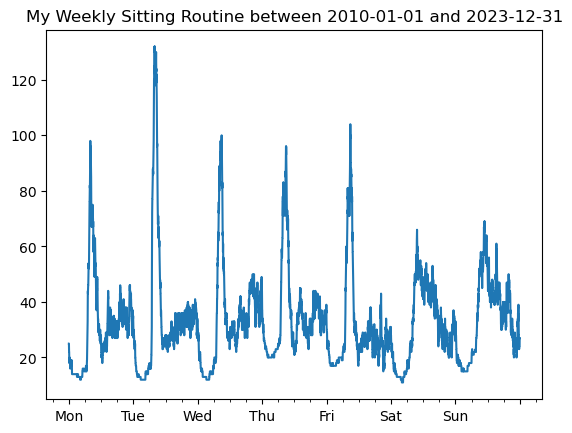

In [25]:
from matplotlib.ticker import FixedLocator, FixedFormatter, AutoMinorLocator

fig, ax = plt.subplots()
ax.plot(allweeks)
locs = [0, 1440, 1440*2, 1440*3, 1440*4, 1440*5, 1440*6, 1440*7]
labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax.set_title(f"My Weekly Sitting Routine between {start.date()} and {end.date()}")
ax.xaxis.set_major_locator(FixedLocator(locs))
ax.xaxis.set_major_formatter(FixedFormatter(labels))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
plt.show()

# Cumulative sittings per day, week, month, year

First, let's create a dataframes with number of sittings and the total time spent sitting per day, week, month, year.
Can then visuualise there. 



In [51]:
#find beginning and end of all the data.
#take starting time convert to date and then back to datetime (for start of the day)
start = pd.to_datetime(min(sittings.StartTime).date())
end = pd.to_datetime(max(sittings.EndTime).date())

print(f"Data from {start.date()} to {end.date()}")

Data from 2013-08-01 to 2023-10-05


In [73]:
#sittings per day
nDays = (end - start).days + 1

dailySittings = pd.DataFrame(columns = ['Date', 'NumSittings', 'MinutesSitting'] )  

for i in range(nDays):
    thisday = start + datetime.timedelta(days=i)
    nextday = start + datetime.timedelta(days=i+1)
    n, mins = activityInPeriod(sittings, thisday, nextday)
    dailySittings.loc[len(dailySittings)] = {'Date': thisday, 'NumSittings': n, 'MinutesSitting': sum(mins)}
    
dailySittings.set_index('Date', inplace=True)
dailySittings.head()

,NumSittings,MinutesSitting
Date,,
2013-08-01,1,10
2013-08-02,1,6
2013-08-03,1,7
2013-08-04,2,14
2013-08-05,0,0


In [ ]:
#TODO make a general function that does all of these.
#def periodicSittings()

In [57]:
#sittings per week 

weeklySittings = pd.DataFrame(columns = ['Date', 'NumSittings', 'MinutesSitting'] )  

nWeeks = int((end - start).days/7) + 1

#monday of first week
startday =  start - datetime.timedelta(days=start.weekday())

for i in range(nWeeks):
    thisday = startday + datetime.timedelta(days=7*i)
    nextday = startday + datetime.timedelta(days=7*(i+1))
    n, mins = activityInPeriod(sittings, thisday, nextday)
    weeklySittings.loc[len(weeklySittings)] = {'Date': thisday, 'NumSittings': n, 'MinutesSitting': sum(mins)}
    
weeklySittings.set_index('Date', inplace=True)
weeklySittings.head()

,NumSittings,MinutesSitting
Date,,
2013-07-29,5,37
2013-08-05,7,46
2013-08-12,8,46
2013-08-19,4,38
2013-08-26,0,0


In [58]:
#sittings per month 
nWeeks = int((end - start).days/7) + 1

monthlySittings = pd.DataFrame(columns = ['Date', 'NumSittings', 'MinutesSitting'] )  

#first of the month
thismonth = datetime.datetime(year=start.year, month=start.month, day=1)
year = thismonth.year
month = thismonth.month

while thismonth < end:
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1
    nextmonth = datetime.datetime(year=year, month=month, day=1)
    n, mins = activityInPeriod(sittings, thismonth, nextmonth)
    monthlySittings.loc[len(monthlySittings)] = {'Date': thismonth, 'NumSittings': n, 'MinutesSitting': sum(mins)}
    thismonth = nextmonth

monthlySittings.set_index('Date', inplace=True)
monthlySittings.head()

,NumSittings,MinutesSitting
Date,,
2013-08-01,24,167
2013-09-01,12,113
2013-10-01,45,459
2013-11-01,40,499
2013-12-01,47,702


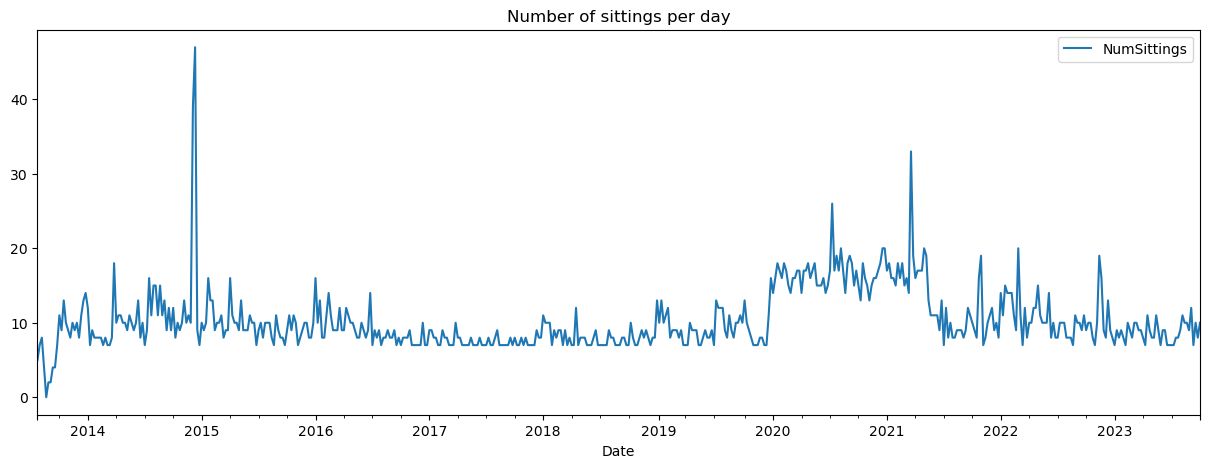

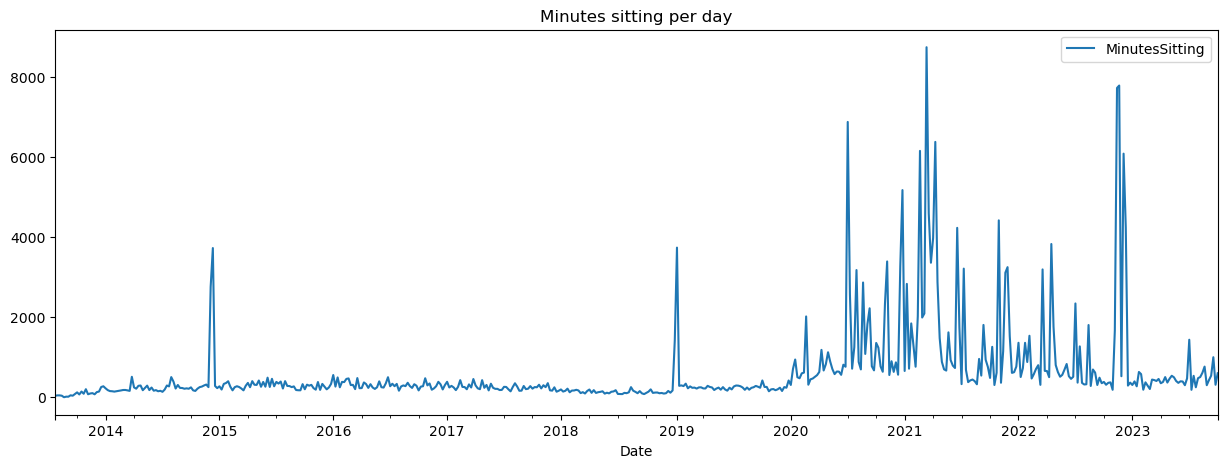

In [68]:
plot = weeklySittings.plot(y='NumSittings', figsize=(15,5), title='Number of sittings per week')
plot = weeklySittings.plot(y='MinutesSitting', figsize=(15,5), title='Minutes sitting per week')

#TODO find out why plot.bar messes up x axis labels
#plot = weeklySittings.plot.bar(y='NumSittings', figsize=(15,5), title='Number of sittings per week')
#plot = weeklySittings.plot.bar(y='MinutesSitting', figsize=(15,5), title='Minutes sitting per week')

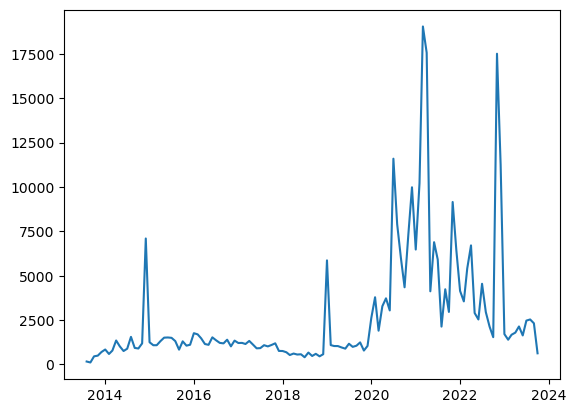

In [77]:
#plot = monthlySittings.plot(y='NumSittings', figsize=(15,5), title='Number of sittings per month')
#plot = monthlySittings.plot(y='MinutesSitting', figsize=(15,5), title='Minutes sitting per month')

#TODO find out why plot.bar messes up x axis labels
#plot = monthlySittings.plot.bar(y='NumSittings', figsize=(15,5), title='Number of sittings per month')
#plot = monthlySittings.plot.bar(y='MinutesSitting', figsize=(15,5), title='Minutes sitting per month')

#plt.plot(monthlySittings.MinutesSitting)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(<Figure size 1250x1870 with 12 Axes>,
 array([<Axes: ylabel='2013'>, <Axes: ylabel='2014'>,
        <Axes: ylabel='2015'>, <Axes: ylabel='2016'>,
        <Axes: ylabel='2017'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

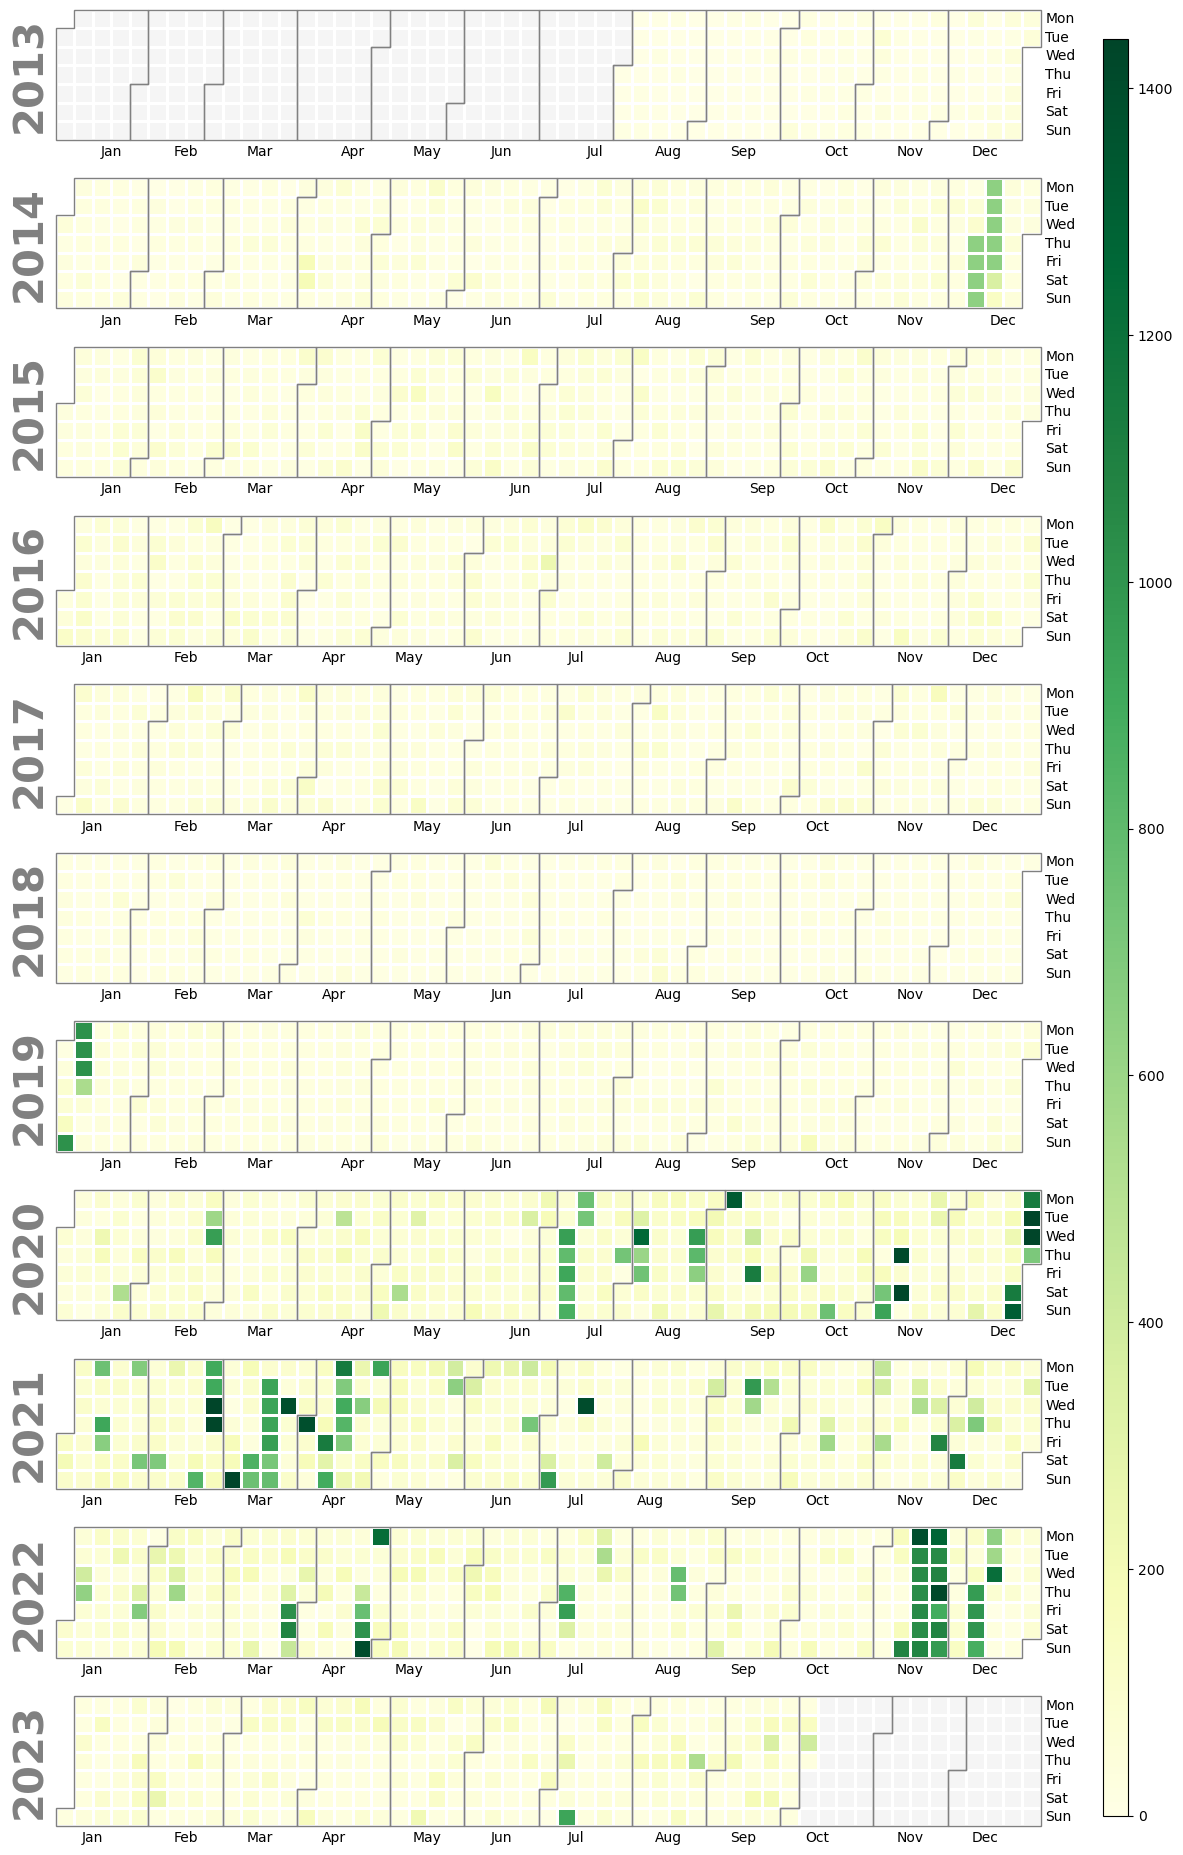

In [47]:
calplot.calplot(dailySittings.MinutesSitting, cmap='YlGn')

# Bar charts

,StartTime,EndTime,SessionType,Comment,Duration
0,2013-08-01 23:10:00,2013-08-01 23:20:00,600.0,\n',600
1,2013-08-02 21:03:30,2013-08-02 21:10:30,360.0,\n',420
2,2013-08-03 14:41:08,2013-08-03 14:48:08,360.0,\n',420
3,2013-08-04 20:58:38,2013-08-04 21:05:38,360.0,\n',420
4,2013-08-04 21:05:47,2013-08-04 21:12:47,360.0,\n',420
